## Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [16]:
# multiple txt files --> one df
from data.data_processing import list_epitopes, load_epitope_trb_data

train_folder = '../data/training_data/'
epitopes = list_epitopes(train_folder)

dfs = []
for epitope in epitopes:
    df = load_epitope_trb_data(train_folder, epitope)
    df['Epitope'] = epitope
    df = df[['Epitope', 'TRB_CDR3', 'Label']]
    dfs.append(df)

df = pd.concat(dfs)
df.head(10)

,Epitope,TRB_CDR3,Label
0,ATDALMTGF,CASRGDTFYEQYF,1
1,ATDALMTGF,CATSDSVAGNQPQHF,1
2,ATDALMTGF,CAISESSSGNNEQFF,1
3,ATDALMTGF,CASSFGGSRLGEETQYF,1
4,ATDALMTGF,CASSPLTGESMSEKLFF,1
5,ATDALMTGF,CAISESSAGFNEQFF,1
6,ATDALMTGF,CSARDTVSSNQPQHF,1
7,ATDALMTGF,CASSYPRTASNQPQHF,1
8,ATDALMTGF,CASSQFFSGEGLYGYTF,1
9,ATDALMTGF,CASSENSNSNQPQHF,1


In [17]:
# find the maximum sequence lengths in both train and test set

from data.data_processing import max_trb_epitope_lengths

max_len_trb, max_len_epitope = max_trb_epitope_lengths(train_folder, '../data/true_set/')

print((max_len_trb, max_len_epitope))

(21, 10)


In [18]:
from external.bio.peptide_feature import parse_features, parse_operator
from external.bio.feature_builder import CombinedPeptideFeatureBuilder

# specify the different interaction map features and the operator that is used to calculate the entries
features_list = parse_features('hydrophob,isoelectric,mass,hydrophil')
operator = parse_operator('absdiff')
feature_builder = CombinedPeptideFeatureBuilder(features_list, operator)

In [19]:
im = feature_builder.generate_peptides_feature(df.iloc[0,1], df.iloc[0,0])
print("TYPE: ", type(im))
print("SHAPE: ", im.shape)

TYPE:  <class 'numpy.ndarray'>
SHAPE:  (13, 9, 4)


In [21]:
# for each tcr-epitope pair, generate an interaction map, zero pad it and store it in df
from data.data_processing import generate_interaction_map, pad

df['interaction_map'] = df.apply(
    lambda row: pad(
        generate_interaction_map(
            row['TRB_CDR3'],
            row['Epitope'],
            'hydrophob,isoelectric,mass,hydrophil',
            'absdiff'
        ), 
        max_len_trb,
        max_len_epitope
    ), 
    axis=1
)
df = df[['interaction_map', 'Label']]

In [22]:
print(df.iloc[0,0].shape)

(21, 10, 4)


## Model

In [29]:
from tensorflow import keras
MODEL_CONFIG = {
  'filters': [(128, 64), (128, 64)],  # two units, each with two convolutional layers, the filter size of layer 1 us 128
  'kernel_size': (3, 3),
  'pool_size': (2, 2),
  'activation': 'relu',
  'padding': 'same',
  'kernel_initializer': 'he_normal',
  'kernel_regularizer': keras.regularizers.l2(0.01),
  'dropout_conv': 0.25,
  'dense_activation': 'relu',
  'dense_units': 32,
  'nr_classes': 1,
  'final_activation': 'sigmoid'
}

In [13]:
from models.CNN_model.model import build_model

model = build_model(MODEL_CONFIG)

model.compile(
    optimizer='rmsprop',
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        'accuracy',
        keras.metrics.AUC(curve="ROC", name="roc_auc"), 
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
    ],
    loss_weights=None,
    sample_weight_mode=None,
    weighted_metrics=None,
    target_tensors=None,
    distribute=None,
)

## Train

In [24]:
# split data into train and validation set
from sklearn.model_selection import train_test_split

X = list(df['interaction_map'])
y = list(df['Label'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# convert data to tf.data.Dataset objects and batch
train_data = tf.data.Dataset.from_tensor_slices((np.array(X_train), np.array(y_train)))
val_data = tf.data.Dataset.from_tensor_slices((np.array(X_val), np.array(y_val)))

train_data = train_data.shuffle(buffer_size=len(train_data), seed=42, reshuffle_each_iteration=True).batch(32)
val_data = val_data.batch(32)

In [26]:
# data imbalance -> weight scaling
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
class_weights_dict

{0: 0.6012269938650306, 1: 2.9696969696969697}

In [17]:
from tensorflow.python.distribute.multi_process_lib import multiprocessing
workers = multiprocessing.cpu_count()

In [18]:
history = model.fit(
    x=train_data,
    epochs=20,
    validation_data=val_data,
    class_weight=class_weights_dict,
    max_queue_size=2,
    use_multiprocessing=True,
    workers=workers,
    verbose=1,
    shuffle=False,
)

Epoch 1/20
368/368 [==============================] - 33s 83ms/step - loss: 3.7080 - accuracy: 0.6202 - roc_auc: 0.5881 - precision: 0.2121 - recall: 0.4626 - val_loss: 1.4356 - val_accuracy: 0.1581 - val_roc_auc: 0.4490 - val_precision: 0.1581 - val_recall: 1.0000
Epoch 2/20
368/368 [==============================] - 31s 85ms/step - loss: 0.8923 - accuracy: 0.6440 - roc_auc: 0.6099 - precision: 0.2233 - recall: 0.4495 - val_loss: 0.6947 - val_accuracy: 0.7508 - val_roc_auc: 0.5784 - val_precision: 0.2022 - val_recall: 0.1957
Epoch 3/20
368/368 [==============================] - 28s 75ms/step - loss: 0.7923 - accuracy: 0.6584 - roc_auc: 0.6371 - precision: 0.2435 - recall: 0.4884 - val_loss: 0.7360 - val_accuracy: 0.6974 - val_roc_auc: 0.5437 - val_precision: 0.1746 - val_recall: 0.2452
Epoch 4/20
368/368 [==============================] - 27s 73ms/step - loss: 0.7632 - accuracy: 0.6804 - roc_auc: 0.6581 - precision: 0.2626 - recall: 0.4965 - val_loss: 0.7023 - val_accuracy: 0.7242 - v

In [29]:
model.save('../models/binary_classification')

INFO:tensorflow:Assets written to: ../models/binary_classification\assets


INFO:tensorflow:Assets written to: ../models/binary_classification\assets


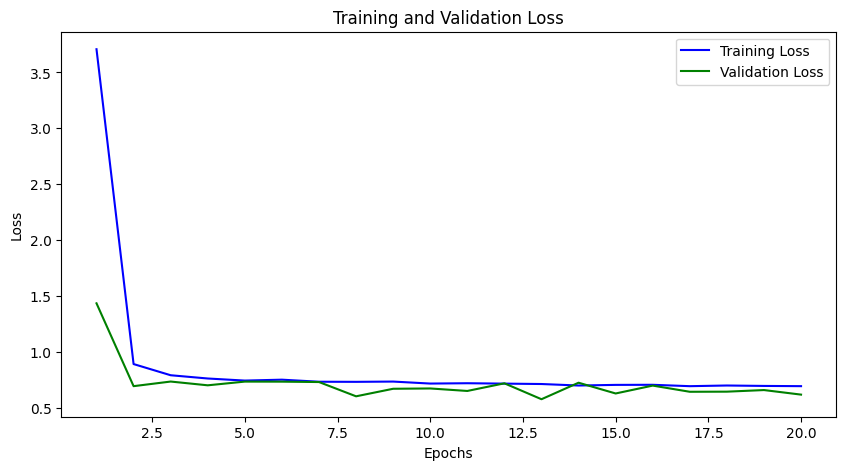

In [19]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, history.history['loss'], color='blue', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], color='green', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

C:\Users\moham\AppData\Local\Temp\ipykernel_18756\2914632935.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, history.history['accuracy'], 'b', label='Accuracy', color='blue')
C:\Users\moham\AppData\Local\Temp\ipykernel_18756\2914632935.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation Accuracy', color='cyan', linestyle='dashed')
C:\Users\moham\AppData\Local\Temp\ipykernel_18756\2914632935.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, history.history['roc_auc'], 'b', label='ROC AUC', color='red'

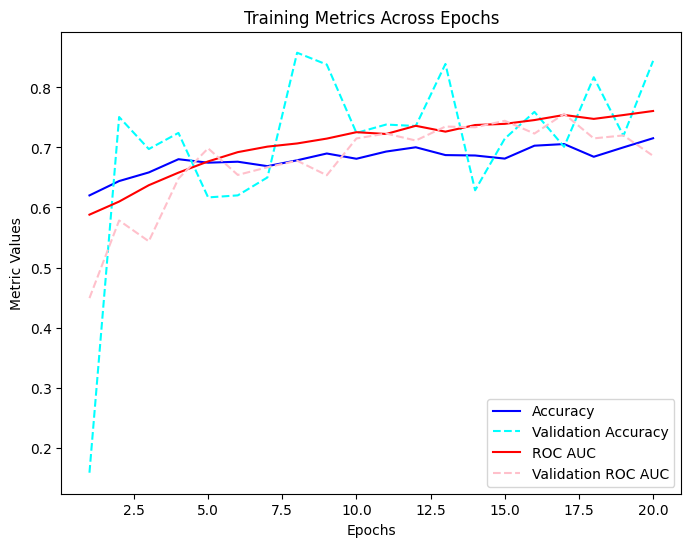

In [20]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, history.history['accuracy'], 'b', label='Accuracy', color='blue')
if 'val_accuracy' in history.history:
    plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation Accuracy', color='cyan', linestyle='dashed')


plt.plot(epochs, history.history['roc_auc'], 'b', label='ROC AUC', color='red')
if 'val_roc_auc' in history.history:
    plt.plot(epochs, history.history['val_roc_auc'], 'b', label='Validation ROC AUC', color='pink', linestyle='dashed')

plt.title('Training Metrics Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metric Values')

plt.legend()

plt.show()


## Test

In [30]:
test_folder = '../data/true_set/'
test_epitopes = list_epitopes(test_folder)

In [31]:
loaded_model = keras.models.load_model('../models/binary_classification')

In [55]:
from sklearn.metrics import roc_auc_score
auc_scores = dict()
for test_epitope in test_epitopes:
    df = load_epitope_trb_data(test_folder, test_epitope)
    df['interaction_map'] = df.apply(
        lambda row: pad(
            generate_interaction_map(
                row['TRB_CDR3'],
                test_epitope,
                'hydrophob,isoelectric,mass,hydrophil',
                'absdiff'
            ), 
            max_len_trb,
            max_len_epitope
        ), 
        axis=1
    )
    df = df[['interaction_map', 'Label']]
    
    imaps = list(df['interaction_map'])
    imaps_tensor = tf.stack(imaps)
    true_labels  = list(df['Label'])
    predicted_scores = loaded_model.predict(imaps_tensor)
    auc = roc_auc_score(true_labels, predicted_scores)
    auc_scores[test_epitope] = auc

13/13 [==============================] - 0s 12ms/step


In [56]:
auc_scores['average'] = sum(auc_scores.values())/len(auc_scores)

auc_scores

{'ATDALMTGF': 0.7847346451997614,
 'CINGVCWTV': 0.6308145054110499,
 'GILGFVFTL': 0.8736893056038985,
 'GLCTLVAML': 0.8049032639196574,
 'GPRLGVRAT': 0.6916221033868093,
 'HPVTKYIM': 0.5847222222222221,
 'KSKRTPMGF': 0.6682242990654206,
 'LLWNGPMAV': 0.7673155273879584,
 'LTDEMIAQY': 0.53952,
 'NLVPMVATV': 0.6480633952029833,
 'NQKLIANQF': 0.6065727699530516,
 'NYNYLYRLF': 0.9449404761904762,
 'RAQAPPPSW': 0.9456790123456791,
 'SPRWYFYYL': 0.6968390804597702,
 'TPRVTGGGAM': 0.77046783625731,
 'TTDPSFLGRY': 0.575139146567718,
 'YLQPRTFLL': 0.7976532997662292,
 'average': 0.7253471111141173}